In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kymatio
!pip install git+https://github.com/mattcraigie/scattering-transform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 1.1 MB/s eta 0:00:00


  Cloning https://github.com/mattcraigie/scattering-transform to /tmp/pip-req-build-mq715uod
  Running command git clone --filter=blob:none --quiet https://github.com/mattcraigie/scattering-transform /tmp/pip-req-build-mq715uod
  Resolved https://github.com/mattcraigie/scattering-transform to commit 5123be05e7a1f66a873b12bb6ae922eb5e18b3a3
  Preparing metadata (setup.py) ... done
  Created wheel for scatteringtransform: filename=scatteringtransform-0.1-py3-none-any.whl size=18901 sha256=2a8656bfbe0f9094104b2bd5b648417cbf91fecdc88fb0b16d1df06b1c4f95ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-496sq0n1/wheels/58/eb/c9/a3a9118ef2f6d69bb24c065787373329a1e6b8f54232bfed5c
Successfully built scatteringtransform


In [ ]:
ls drive/MyDrive/ai4phys2024_hackathon_files/HSC_NG/

Cell_ell_100_2100_8bins_gama09h_gama15h.hdf5
HSC_NG_ConvergenceMaps.ipynb
HSC_NG_ConvergenceMaps_.ipynb
HSC-Y1_convergence_kappaEBmodes_6areas_4zbins_2arcmin.hdf5
mock_cosmovaried_HSC-Y1_convergence_kappaEmode_6areas_4zbins_2arcmin.hdf5
mock_fiducial_HSC-Y1_convergence_kappaEmode_6areas_4zbins_2arcmin.hdf5
omegam_sigma8_design3.dat
ps_gama09h.npy
ps_gama15h.npy
stats_HSC-Y1_convergence_6areas_4zbins_6smootingscales.hdf5
stats_mockcosmovaried_HSC-Y1_convergence_6areas_100cosmo_4zbins_50real_6smootingscales.hdf5
stats_mockfiducial_HSC-Y1_convergence_6areas_4zbins_2267real_6smootingscales.hdf5
v0_4_patches_pre_processed_data.h5


In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
from scattering_transform.scattering_transform import ScatteringTransform2d
from scattering_transform.filters import Morlet
from scattering_transform.reducer import Reducer
device = torch.device('cuda:0')

In [ ]:

HSCrealdata_kappamaps = h5py.File('drive/MyDrive/ai4phys2024_hackathon_files/HSC_NG/HSC-Y1_convergence_kappaEBmodes_6areas_4zbins_2arcmin.hdf5')

In [ ]:
HSCrealdata_kappamaps.keys(),HSCrealdata_kappamaps['data'].keys() #names for area patches

(<KeysViewHDF5 ['data']>,
 <KeysViewHDF5 ['gama09h', 'gama15h', 'hectomap', 'vvds', 'wide12h', 'xmm']>)

In [ ]:
HSCrealdata_kappamaps['data/gama09h'].keys()

<KeysViewHDF5 ['z1', 'z2', 'z3', 'z4']>

In [ ]:
HSCrealdata_kappamaps['data/gama09h']['z1'][:].shape #data for each redshift bin. This version has 2 maps (for E-modes and B-modes), for 1 smoothing scale (2 arcmin). The map for this patch is a rectangular with 432x701 pixels.

(2, 1, 432, 701)

0.020 0.020


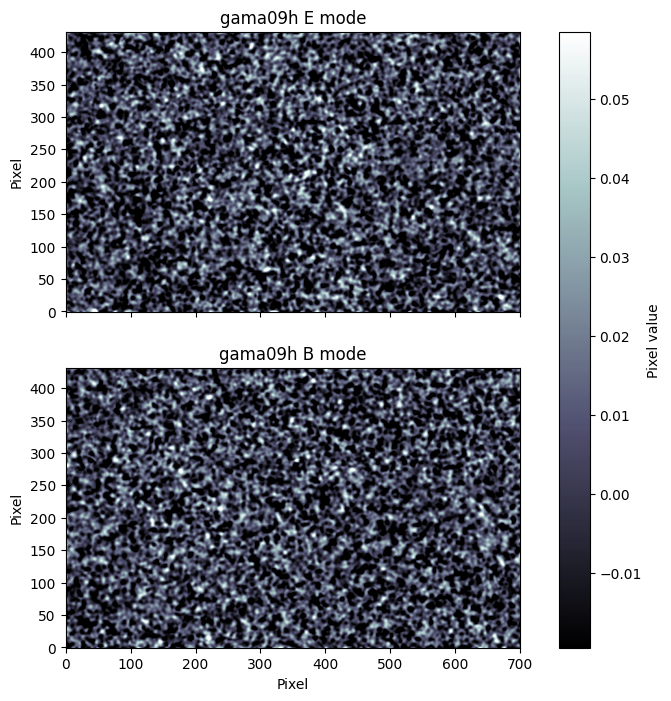

0.019 0.019


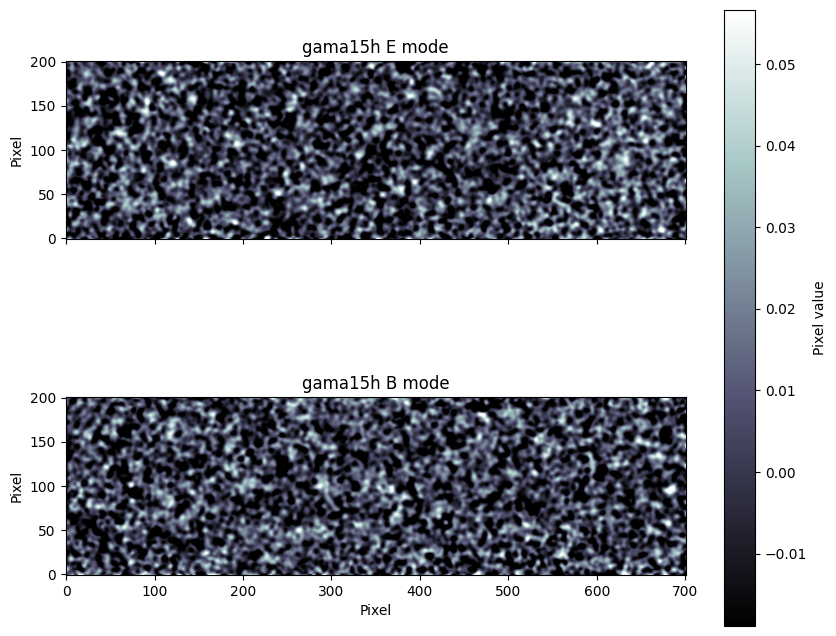

0.022 0.022


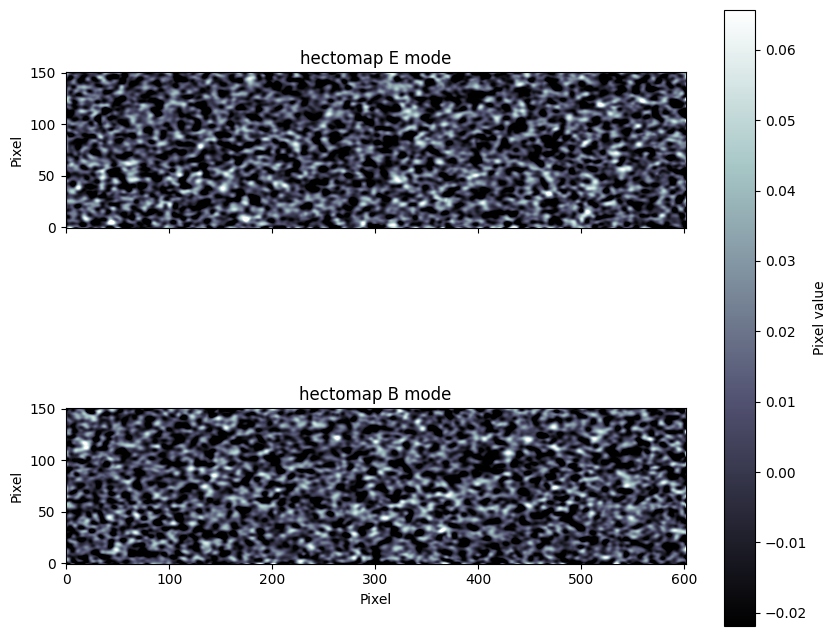

0.020 0.019


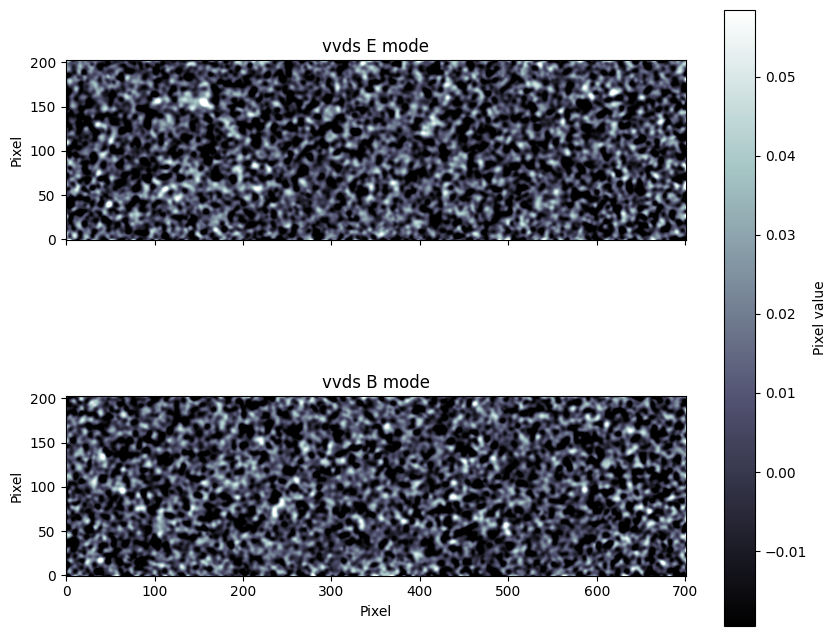

0.019 0.019


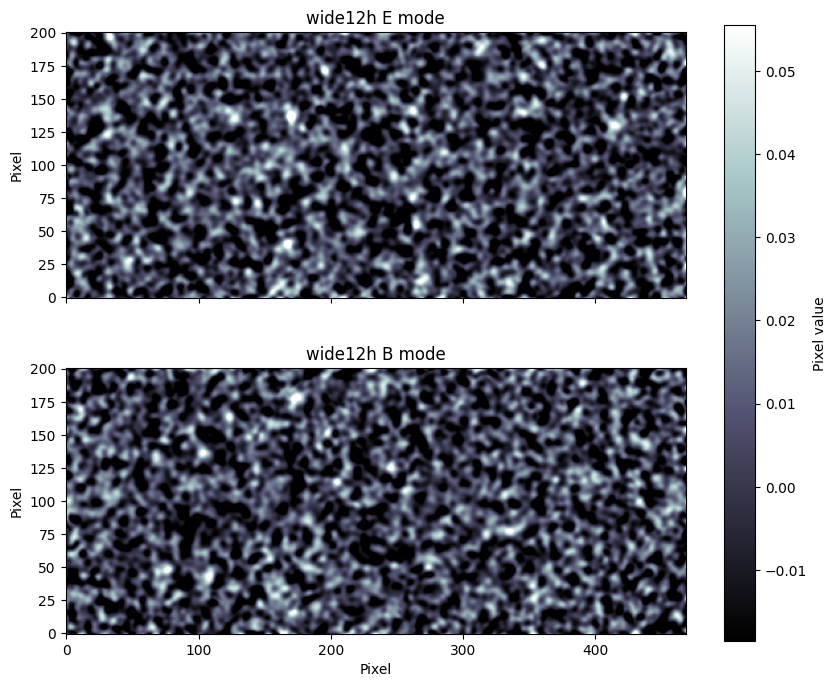

0.020 0.020


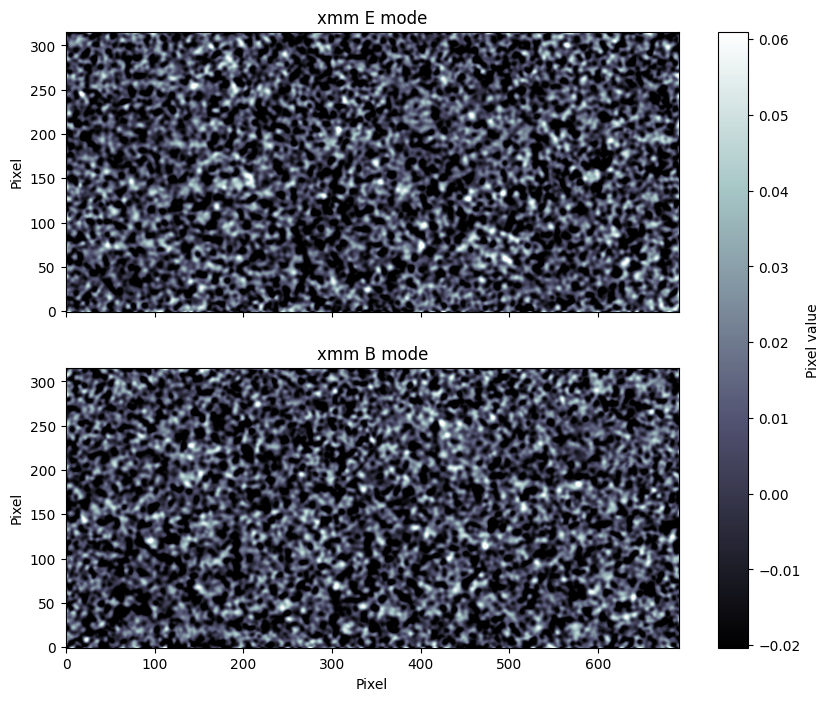

In [ ]:

areas = list(HSCrealdata_kappamaps['data'].keys())
for area in areas:
    kappa_Emode = HSCrealdata_kappamaps['data/{0}'.format(area)]['z1'][:][0,0,:,:]
    kappa_Bmode = HSCrealdata_kappamaps['data/{0}'.format(area)]['z1'][:][1,0,:,:]
    std_kappa_Emode = np.std(kappa_Emode)
    std_kappa_Bmode = np.std(kappa_Bmode)
    print('%.3lf %.3lf'%(std_kappa_Emode,std_kappa_Bmode))
    f,ax = plt.subplots(2,1,figsize=(10,8),sharex=True,sharey=True)
    ax[0].set_title('{0} E mode'.format(area))
    ax[1].set_title('{0} B mode'.format(area))
    ax[0].imshow(kappa_Emode,origin='lower',cmap='bone',vmin=-std_kappa_Emode,vmax=3*std_kappa_Emode)
    c1 = ax[1].imshow(kappa_Bmode,origin='lower',cmap='bone',vmin=-std_kappa_Bmode,vmax=3*std_kappa_Bmode)
    ax[0].set_ylabel('Pixel')
    ax[1].set_ylabel('Pixel')
    ax[1].set_xlabel('Pixel')
    b1 = plt.colorbar(c1,ax=ax)
    b1.set_label('Pixel value')
    #plt.tight_layout()
    #plt.subplots_adjust(hspace=0.1)
    plt.show()

In [ ]:
HSCfiducial_kappamaps = h5py.File('drive/MyDrive/ai4phys2024_hackathon_files/HSC_NG/mock_fiducial_HSC-Y1_convergence_kappaEmode_6areas_4zbins_2arcmin.hdf5')
HSCcosmovaried_kappamaps = h5py.File('drive/MyDrive/ai4phys2024_hackathon_files/HSC_NG/mock_cosmovaried_HSC-Y1_convergence_kappaEmode_6areas_4zbins_2arcmin.hdf5')

In [ ]:
stats_HSCrealdata_kappamaps = h5py.File('drive/MyDrive/ai4phys2024_hackathon_files/HSC_NG/stats_HSC-Y1_convergence_6areas_4zbins_6smootingscales.hdf5')
stats_HSCfiducial_kappamaps = h5py.File('drive/MyDrive/ai4phys2024_hackathon_files/HSC_NG/stats_mockfiducial_HSC-Y1_convergence_6areas_4zbins_2267real_6smootingscales.hdf5')
stats_HSCcosmovaried_kappamaps = h5py.File('drive/MyDrive/ai4phys2024_hackathon_files/HSC_NG/stats_mockcosmovaried_HSC-Y1_convergence_6areas_100cosmo_4zbins_50real_6smootingscales.hdf5')

In [ ]:
stats_HSCrealdata_kappamaps['statistics/realdata/gama09h/'].keys(),stats_HSCfiducial_kappamaps['statistics/fiducial/gama09h/'].keys(),stats_HSCrealdata_kappamaps['statistics/realdata/gama09h/'].keys(),stats_HSCcosmovaried_kappamaps['statistics/cosmovaried/gama09h/'].keys()

(<KeysViewHDF5 ['C_ell', 'Minima', 'PDF', 'Peaks']>,
 <KeysViewHDF5 ['C_ell', 'Minima', 'PDF', 'Peaks']>,
 <KeysViewHDF5 ['C_ell', 'Minima', 'PDF', 'Peaks']>,
 <KeysViewHDF5 ['C_ell', 'Minima', 'PDF', 'Peaks']>)

In [ ]:
stats_HSCrealdata_kappamaps['statistics/realdata/gama09h/C_ell']['z1'][:].shape, stats_HSCfiducial_kappamaps['statistics/fiducial/gama09h/C_ell']['z1'][:].shape, stats_HSCcosmovaried_kappamaps['statistics/cosmovaried/gama09h/C_ell/model1']['z1'][:].shape

((3, 6, 14), (2, 2268, 6, 14), (1, 50, 6, 14))

In [ ]:
J, L, size = 4, 6, 128
filters = Morlet(J, L, size)
filters.to(device)
filters.clip_filters()
st = ScatteringTransform2d(filters)
st.to(device)
reducer = Reducer(filters, reduction='rot_avg')
def reduced_st(x):
    x = st(x)
    print(x[0].shape, x[1].shape, x[2].shape)
    x = reducer(x)
    return x
data = torch.randn((5, 1, 128, 128)).to(device)
result = reduced_st(data)
print(result.shape)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([5, 1, 1]) torch.Size([5, 1, 6, 128]) torch.Size([5, 1, 6, 128, 6, 128])
torch.Size([5, 1, 22])


In [ ]:
from kymatio.torch import Scattering2D
import matplotlib.pyplot as plt
import torch
import time
#device='cuda'
scattering = Scattering2D(J=4, L=6,shape=(128,128))
scattering = scattering.cuda()

In [ ]:
start = time.time()
img = HSCrealdata_kappamaps['data/{0}'.format(area)]['z1'][:][0,0,0:128,0:128]
img = img.astype('float32')
img = torch.from_numpy(img).to(device).contiguous()

# Compute the scattering coefficients
#coefs = scattering(img)
#avg_coefs = torch.mean(coefs, dim=(-1,-2))
img = img.unsqueeze(0).unsqueeze(0)
avg_coefs = reduced_st(img)
print(avg_coefs.shape)
end = time.time()

torch.Size([1, 1, 1]) torch.Size([1, 1, 6, 128]) torch.Size([1, 1, 6, 128, 6, 128])
torch.Size([1, 1, 22])


In [ ]:
print('Elapsed time: ',end-start,' s')

Elapsed time:  0.017252206802368164  s


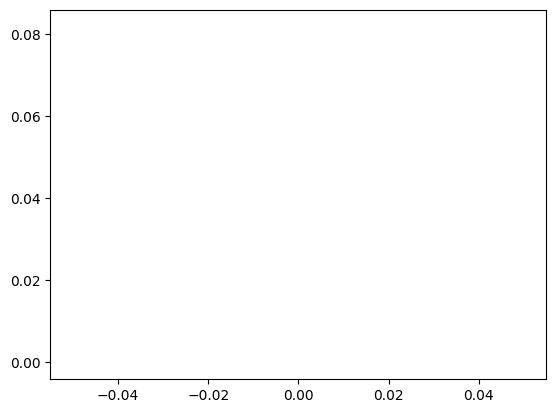

In [ ]:
plt.plot(avg_coefs.squeeze(0).cpu().numpy())


In [ ]:
500*6*4 *0.2 /60

40.0

In [ ]:
raw_data = h5py.File('/content/drive/MyDrive/v0_4_patches_pre_processed_data.h5')

In [ ]:
raw_data['cosmo_0']['gama15h']['z1'].shape

(5, 5, 128, 128)

In [ ]:
J, L, size = 4, 6, 128
filters = Morlet(size, J, L)
filters.to(device)
filters.clip_filters()
st = ScatteringTransform2d(filters)
st.to(device)
reducer = Reducer(filters, reduction='none')
def reduced_st(x):
    x = st(x)
    x = reducer(x)
    return x
data = torch.randn((5, 1, 128, 128)).to(device)
result = reduced_st(data)
print(result.shape)

torch.Size([5, 1, 241])


In [ ]:
all_data = {}
redshift = 'z2'
scattering = Scattering2D(J=4, L=6,shape=(128,128))
scattering = scattering.cuda()
cosmo_keys = list(raw_data.keys())
for cosmo in cosmo_keys:
  tmp = []
  print(cosmo)
  for sky_patch in raw_data[cosmo].keys():
    for mock in range(raw_data[cosmo][sky_patch][redshift].shape[0]):
      for patch in range(raw_data[cosmo][sky_patch][redshift].shape[1]):
        img = raw_data[cosmo][sky_patch][redshift][mock,patch,:,:]
        #print(img.shape)
        #plt.figure()
        #plt.imshow(img)
        #plt.show()
        img = img.astype('float32')
        img = torch.from_numpy(img).to(device).contiguous()
        img = img.unsqueeze(0).unsqueeze(0)
        avg_coefs = reduced_st(img)
        # Compute the scattering coefficients
        #coefs = scattering(img)
        #avg_coefs = torch.mean(coefs, dim=(-1,-2))
        tmp.append(avg_coefs.cpu().numpy())
  tmp = np.array(tmp)
  all_data[cosmo] = tmp


to_save = np.array(list(all_data.values()))
to_save = to_save.squeeze(2).squeeze(2)
to_save.shape
np.save('v2.1_avg_coefs_'+redshift+'.npy',to_save)

cosmo_0
cosmo_1
cosmo_10
cosmo_11
cosmo_12
cosmo_13
cosmo_14
cosmo_15
cosmo_16
cosmo_17
cosmo_18
cosmo_19
cosmo_2
cosmo_20
cosmo_21
cosmo_22
cosmo_23
cosmo_24
cosmo_25
cosmo_26
cosmo_27
cosmo_28
cosmo_29
cosmo_3
cosmo_30
cosmo_31
cosmo_32
cosmo_33
cosmo_34
cosmo_35
cosmo_36
cosmo_37
cosmo_38
cosmo_39
cosmo_4
cosmo_40
cosmo_41
cosmo_42
cosmo_43
cosmo_44
cosmo_45
cosmo_46
cosmo_47
cosmo_48
cosmo_49
cosmo_5
cosmo_50
cosmo_51
cosmo_52
cosmo_53
cosmo_54
cosmo_55
cosmo_56
cosmo_57
cosmo_58
cosmo_59
cosmo_6
cosmo_60
cosmo_61
cosmo_62
cosmo_63
cosmo_64
cosmo_65
cosmo_66
cosmo_67
cosmo_68
cosmo_69
cosmo_7
cosmo_70
cosmo_71
cosmo_72
cosmo_73
cosmo_74
cosmo_75
cosmo_76
cosmo_77
cosmo_78
cosmo_79
cosmo_8
cosmo_80
cosmo_81
cosmo_82
cosmo_83
cosmo_84
cosmo_85
cosmo_86
cosmo_87
cosmo_88
cosmo_89
cosmo_9
cosmo_90
cosmo_91
cosmo_92
cosmo_93
cosmo_94
cosmo_95
cosmo_96
cosmo_97
cosmo_98
cosmo_99


In [ ]:
J, L, size = 4, 6, 128
filters = Morlet(size, J, L)
filters.to(device)
filters.clip_filters()
st = ScatteringTransform2d(filters)
st.to(device)
reducer = Reducer(filters, reduction='rot_avg')
def reduced_st(x):
    x = st(x)
    x = reducer(x)
    return x
data = torch.randn((5, 1, 128, 128)).to(device)
result = reduced_st(data)
print(result.shape)

all_data = {}
#scattering = Scattering2D(J=4, L=6,shape=(128,128))
#scattering = scattering.cuda()
cosmo_keys = list(raw_data.keys())
for cosmo in cosmo_keys:
  print(cosmo)
  redshift_tmp = []
  for sky_patch in raw_data[cosmo].keys():
    for i, redshift in enumerate(raw_data[cosmo][sky_patch].keys()):
      tmp = []
      for mock in range(raw_data[cosmo][sky_patch][redshift].shape[0]):
        for patch in range(raw_data[cosmo][sky_patch][redshift].shape[1]):
          img = raw_data[cosmo][sky_patch][redshift][mock,patch,:,:]
          img = img.astype('float32')
          img = torch.from_numpy(img).to(device).contiguous()
          img = img.unsqueeze(0).unsqueeze(0)
          avg_coefs = reduced_st(img)
          # Compute the scattering coefficients
          #coefs = scattering(img)
          #avg_coefs = torch.mean(coefs, dim=(-1,-2))
          tmp.append(avg_coefs.cpu().numpy())
      tmp = np.array(tmp).squeeze(1).squeeze(1)
      if i==0:
        redshift_tmp = tmp
      else:
        redshift_tmp = np.vstack((redshift_tmp,tmp))
  all_data[cosmo] = redshift_tmp


to_save = np.array(list(all_data.values()))
#to_save = to_save.squeeze(2).squeeze(2)
to_save.shape
np.save('v3_avg_coefs_all_z.npy',to_save)

torch.Size([5, 1, 11])
cosmo_0
cosmo_1
cosmo_10
cosmo_11
cosmo_12
cosmo_13
cosmo_14
cosmo_15
cosmo_16
cosmo_17
cosmo_18
cosmo_19
cosmo_2
cosmo_20
cosmo_21
cosmo_22
cosmo_23
cosmo_24
cosmo_25
cosmo_26
cosmo_27
cosmo_28
cosmo_29
cosmo_3
cosmo_30
cosmo_31
cosmo_32
cosmo_33
cosmo_34
cosmo_35
cosmo_36
cosmo_37
cosmo_38
cosmo_39
cosmo_4
cosmo_40
cosmo_41
cosmo_42
cosmo_43
cosmo_44
cosmo_45
cosmo_46
cosmo_47
cosmo_48
cosmo_49
cosmo_5
cosmo_50
cosmo_51
cosmo_52
cosmo_53
cosmo_54
cosmo_55
cosmo_56
cosmo_57
cosmo_58
cosmo_59
cosmo_6
cosmo_60
cosmo_61
cosmo_62
cosmo_63
cosmo_64
cosmo_65
cosmo_66
cosmo_67
cosmo_68
cosmo_69
cosmo_7
cosmo_70
cosmo_71
cosmo_72
cosmo_73
cosmo_74
cosmo_75
cosmo_76
cosmo_77
cosmo_78
cosmo_79
cosmo_8
cosmo_80
cosmo_81
cosmo_82
cosmo_83
cosmo_84
cosmo_85
cosmo_86
cosmo_87
cosmo_88
cosmo_89
cosmo_9
cosmo_90
cosmo_91
cosmo_92
cosmo_93
cosmo_94
cosmo_95
cosmo_96
cosmo_97
cosmo_98
cosmo_99


In [ ]:
for sky_patch in raw_data[cosmo].keys():
  print(raw_data[cosmo][sky_patch]['z2'].shape)

(5, 15, 128, 128)
(5, 5, 128, 128)
(5, 4, 128, 128)
(5, 5, 128, 128)
(5, 3, 128, 128)
(5, 10, 128, 128)


In [ ]:
all_data = {}
cosmo_keys = list(raw_data.keys())

J, L, size = 4, 6, 128
filters = Morlet(size, J, L)
filters.to(device)
filters.clip_filters()
st = ScatteringTransform2d(filters)
st.to(device)
reducer = Reducer(filters, reduction='rot_avg')
def reduced_st(x):
    x = st(x)
    x = reducer(x)
    return x
data = torch.randn((5, 1, 128, 128)).to(device)
result = reduced_st(data)
print(result.shape)


for cosmo in cosmo_keys:
    # Obtener todos los redshifts únicos en todas las sky_patches para esta cosmología
    unique_redshifts = sorted({redshift for sky_patch in raw_data[cosmo].keys()
                                        for redshift in raw_data[cosmo][sky_patch].keys()})
    print(cosmo)

    all_cosmo_data = []
    for redshift in unique_redshifts:
        redshift_data = []
        for sky_patch in raw_data[cosmo].keys():
            if redshift in raw_data[cosmo][sky_patch]:
                for mock in range(raw_data[cosmo][sky_patch][redshift].shape[0]):
                    for patch in range(raw_data[cosmo][sky_patch][redshift].shape[1]):
                        img = raw_data[cosmo][sky_patch][redshift][mock, patch, :, :]
                        img = img.astype('float32')
                        img = torch.from_numpy(img).to(device).contiguous()
                        img = img.unsqueeze(0).unsqueeze(0)
                        avg_coefs = reduced_st(img)
                        redshift_data.append(avg_coefs.cpu().numpy())
        all_cosmo_data.extend(redshift_data)

    all_data[cosmo] = np.array(all_cosmo_data)

# Convertir el diccionario en un arreglo de NumPy
to_save = np.array(list(all_data.values()))
to_save = to_save.squeeze(2).squeeze(2)
print(to_save.shape)  # Esto te dará la forma (N_cosmologías, N_redshifts x M_sky_patches x K_chunks, N_coefficients)

np.save('v3_avg_coefs_all_z.npy', to_save)

torch.Size([5, 1, 11])
cosmo_0
cosmo_1
cosmo_10
cosmo_11
cosmo_12
cosmo_13
cosmo_14
cosmo_15
cosmo_16
cosmo_17
cosmo_18
cosmo_19
cosmo_2
cosmo_20
cosmo_21
cosmo_22
cosmo_23
cosmo_24
cosmo_25
cosmo_26
cosmo_27
cosmo_28
cosmo_29
cosmo_3
cosmo_30
cosmo_31
cosmo_32
cosmo_33
cosmo_34
cosmo_35
cosmo_36
cosmo_37
cosmo_38
cosmo_39
cosmo_4
cosmo_40
cosmo_41
cosmo_42
cosmo_43
cosmo_44
cosmo_45
cosmo_46
cosmo_47
cosmo_48
cosmo_49
cosmo_5
cosmo_50
cosmo_51
cosmo_52
cosmo_53
cosmo_54
cosmo_55
cosmo_56
cosmo_57
cosmo_58
cosmo_59
cosmo_6
cosmo_60
cosmo_61
cosmo_62
cosmo_63
cosmo_64
cosmo_65
cosmo_66
cosmo_67
cosmo_68
cosmo_69
cosmo_7
cosmo_70
cosmo_71
cosmo_72
cosmo_73
cosmo_74
cosmo_75
cosmo_76
cosmo_77
cosmo_78
cosmo_79
cosmo_8
cosmo_80
cosmo_81
cosmo_82
cosmo_83
cosmo_84
cosmo_85
cosmo_86
cosmo_87
cosmo_88
cosmo_89
cosmo_9
cosmo_90
cosmo_91
cosmo_92
cosmo_93
cosmo_94
cosmo_95
cosmo_96
cosmo_97
cosmo_98
cosmo_99
(100, 840, 11)


In [ ]:
all_data = {}
cosmo_keys = list(raw_data.keys())
for cosmo in cosmo_keys:
    # Obtener todos los redshifts únicos en todas las sky_patches para esta cosmología
    unique_redshifts = sorted({redshift for sky_patch in raw_data[cosmo].keys()
                                        for redshift in raw_data[cosmo][sky_patch].keys()})

    all_cosmo_data = []
    for redshift in unique_redshifts:
        redshift_data = []
        for sky_patch in raw_data[cosmo].keys():
            if redshift in raw_data[cosmo][sky_patch]:
                for mock in range(raw_data[cosmo][sky_patch][redshift].shape[0]):
                    for patch in range(raw_data[cosmo][sky_patch][redshift].shape[1]):
                        img = raw_data[cosmo][sky_patch][redshift][mock, patch, :, :]
                        img = img.astype('float32')
                        img = torch.from_numpy(img).to(device).contiguous()
                        img = img.unsqueeze(0).unsqueeze(0)
                        avg_coefs = reduced_st(img)
                        redshift_data.append(avg_coefs.cpu().numpy())
        all_cosmo_data.extend(redshift_data)

    all_data[cosmo] = np.array(all_cosmo_data)

# Convertir el diccionario en un arreglo de NumPy
to_save = np.array(list(all_data.values()))
to_save = to_save.squeeze(2).squeeze(2)
print(to_save.shape)  # Esto te dará la forma (N_cosmologías, N_redshifts x M_sky_patches x K_chunks, N_coefficients)

np.save('v3_avg_coefs_all_z.npy', to_save)

torch.Size([1, 1, 1]) torch.Size([1, 1, 6, 128]) torch.Size([1, 1, 6, 128, 6, 128])
torch.Size([1, 1, 1]) torch.Size([1, 1, 6, 128]) torch.Size([1, 1, 6, 128, 6, 128])
torch.Size([1, 1, 1]) torch.Size([1, 1, 6, 128]) torch.Size([1, 1, 6, 128, 6, 128])
torch.Size([1, 1, 1]) torch.Size([1, 1, 6, 128]) torch.Size([1, 1, 6, 128, 6, 128])
torch.Size([1, 1, 1]) torch.Size([1, 1, 6, 128]) torch.Size([1, 1, 6, 128, 6, 128])
torch.Size([1, 1, 1]) torch.Size([1, 1, 6, 128]) torch.Size([1, 1, 6, 128, 6, 128])
torch.Size([1, 1, 1]) torch.Size([1, 1, 6, 128]) torch.Size([1, 1, 6, 128, 6, 128])
torch.Size([1, 1, 1]) torch.Size([1, 1, 6, 128]) torch.Size([1, 1, 6, 128, 6, 128])
torch.Size([1, 1, 1]) torch.Size([1, 1, 6, 128]) torch.Size([1, 1, 6, 128, 6, 128])
torch.Size([1, 1, 1]) torch.Size([1, 1, 6, 128]) torch.Size([1, 1, 6, 128, 6, 128])
torch.Size([1, 1, 1]) torch.Size([1, 1, 6, 128]) torch.Size([1, 1, 6, 128, 6, 128])
torch.Size([1, 1, 1]) torch.Size([1, 1, 6, 128]) torch.Size([1, 1, 6, 128, 6

KeyboardInterrupt: 

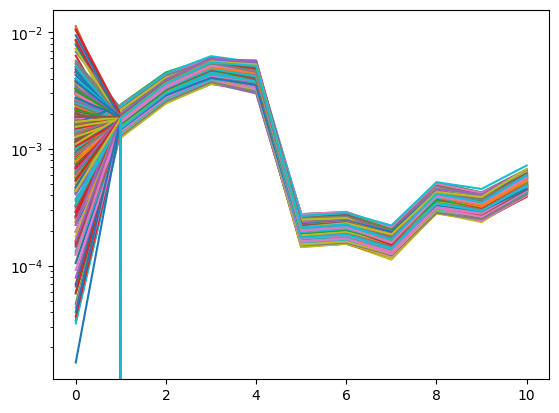

In [ ]:
plt.figure()
tmp = np.load('v3_avg_coefs_all_z.npy')
for i in range(840):
  plt.plot(tmp[0,i,:])
plt.yscale('log')

In [ ]:
tmp1 = np.load('v2.1_avg_coefs_z2.npy')
tmp3 = np.load('v3_avg_coefs_all_z.npy')
print(tmp1.shape)
print(tmp3.shape)

(100, 210, 241)
(100, 200, 11)


In [ ]:
for i,redshift in enumerate(raw_data[cosmo][sky_patch].keys()):
  print(i,redshift)


0 z1
1 z2
2 z3
3 z4


In [ ]:
all_data.keys()

dict_keys(['cosmo_0', 'cosmo_1', 'cosmo_10', 'cosmo_11', 'cosmo_12', 'cosmo_13', 'cosmo_14', 'cosmo_15', 'cosmo_16', 'cosmo_17', 'cosmo_18', 'cosmo_19', 'cosmo_2', 'cosmo_20', 'cosmo_21', 'cosmo_22', 'cosmo_23', 'cosmo_24', 'cosmo_25', 'cosmo_26', 'cosmo_27', 'cosmo_28', 'cosmo_29', 'cosmo_3', 'cosmo_30', 'cosmo_31', 'cosmo_32', 'cosmo_33', 'cosmo_34', 'cosmo_35', 'cosmo_36', 'cosmo_37', 'cosmo_38', 'cosmo_39', 'cosmo_4', 'cosmo_40', 'cosmo_41', 'cosmo_42', 'cosmo_43', 'cosmo_44', 'cosmo_45', 'cosmo_46', 'cosmo_47', 'cosmo_48', 'cosmo_49', 'cosmo_5', 'cosmo_50', 'cosmo_51', 'cosmo_52', 'cosmo_53', 'cosmo_54', 'cosmo_55', 'cosmo_56', 'cosmo_57', 'cosmo_58', 'cosmo_59', 'cosmo_6', 'cosmo_60', 'cosmo_61', 'cosmo_62', 'cosmo_63', 'cosmo_64', 'cosmo_65', 'cosmo_66', 'cosmo_67', 'cosmo_68', 'cosmo_69', 'cosmo_7', 'cosmo_70', 'cosmo_71', 'cosmo_72', 'cosmo_73', 'cosmo_74', 'cosmo_75', 'cosmo_76', 'cosmo_77', 'cosmo_78', 'cosmo_79', 'cosmo_8', 'cosmo_80', 'cosmo_81', 'cosmo_82', 'cosmo_83', 'c

In [ ]:
to_save = np.array(list(all_data.values()))
to_save = to_save.squeeze(2).squeeze(2)
to_save.shape
np.save('avg_coefs_'+redshift+'.npy',to_save)

In [ ]:
to_save.shape

(100, 210, 22)

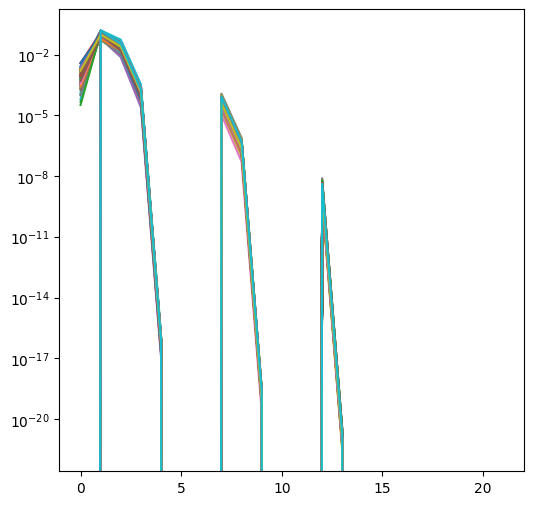

In [ ]:
plt.figure(figsize=(6,6))
for i in range(to_save.shape[1]):
  plt.plot(to_save[1,i,:])
#plt.xscale('log')
plt.yscale('log')

In [ ]:
keys = raw_data.keys()
list(keys)[:10]

['cosmo_0',
 'cosmo_1',
 'cosmo_10',
 'cosmo_11',
 'cosmo_12',
 'cosmo_13',
 'cosmo_14',
 'cosmo_15',
 'cosmo_16',
 'cosmo_17']

In [ ]:
np.min(to_save)

-0.005738129

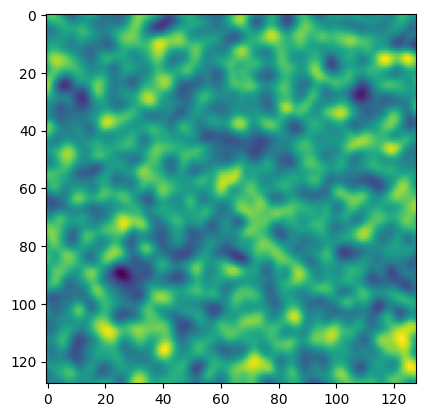

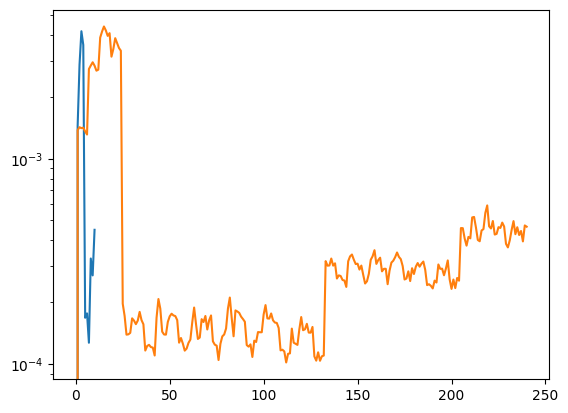

In [ ]:
device = torch.device('cuda:0')
J, L, size = 4, 6, 128
filters = Morlet(size, J, L)
filters.to(device)
filters.clip_filters()
st = ScatteringTransform2d(filters)
st.to(device)
reducer = Reducer(filters, reduction='rot_avg')
def reduced_st(x):
    x = st(x)
    x = reducer(x)
    return x


img = raw_data[cosmo][sky_patch][redshift][mock,patch,:,:]
img = img.astype('float32')

plt.figure()
plt.imshow(img)
img = torch.from_numpy(img).to(device).contiguous()


kymatio_coefs = scattering(img)
kymatio_coefs = torch.mean(kymatio_coefs, dim=(-1,-2)).cpu().numpy()

img = img.unsqueeze(0).unsqueeze(0)

coef = reduced_st(img).cpu().numpy().squeeze(0).squeeze(0)
plt.figure()
plt.plot(coef)
plt.plot(kymatio_coefs)
plt.yscale('log')

In [ ]:
tensor([0.7524])
tensor([0.7146])
